# Import

In [ ]:
!pip install openai llama_index

In [ ]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader # for file loading and vectorization
from llama_index.core.postprocessor import LLMRerank # LLM-based reranking module
# Embeddings and models support from OpenAI
import openai
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings # setting global framework parameters
import gdown # For downloading from google disk
import textwrap # Wrap for text in print

Translated with DeepL.com (free version)

# Load document, model and test query

Specify the OpenAI key

In [ ]:
import getpass # to work with passwords
import os # to work with environment and file system

# Request key input from OpenAI
os.environ["OPENAI_API_KEY"] = getpass.getpass("Input OpenAI API Key:")

Введите OpenAI API Key:··········


In [ ]:
# Set the global default settings
# LLM (gpt-3.5-turbo)
Settings.llm = OpenAI(model_name="gpt-3.5-turbo", temperature=0.1, request_timeout=1000, max_retries=3) # Default LLM

Settings.chunk_size = 512 # size of chunks into which we split the document

Let's download the Introduction to Python Programming text by Open Stax in English and ask questions to it.

In [ ]:
!mkdir -p 'data/'
gdown.download("https://drive.google.com/uc?id=1ZuJcDRvBHpe3GX6XE2SArs8yvWngyLUe", "data/web.pdf")

Downloading...
From: https://drive.google.com/uc?id=1ZuJcDRvBHpe3GX6XE2SArs8yvWngyLUe
To: /content/data/web.pdf
100%|██████████| 11.6M/11.6M [00:00<00:00, 45.6MB/s]


'data/web.pdf'

In [ ]:
# Upload all documents from the folder (there is one file)
documents = SimpleDirectoryReader("./data").load_data()

We translate the document into embedding space and form a vector repository.

In [ ]:
index = VectorStoreIndex.from_documents(
    documents,
)

Model request

In [ ]:
query_engine = index.as_query_engine(
    similarity_top_k=10,
    node_postprocessors=[
        LLMRerank(
            choice_batch_size=5,
            top_n=2,
        )
    ],
)
response = query_engine.query(
    "What is a Multiple inheritance?",
)

# Set the line width (e.g. 80 characters)
wrapped_response = textwrap.fill(str(response), width=100)

print(wrapped_response)

Multiple inheritance is a type of inheritance in which one class inherits from multiple classes.
When a class is inherited from multiple classes, it has all the superclasses listed in the class
definition inheritance list.


The answer is similar to the answer in the book, but has some differences.

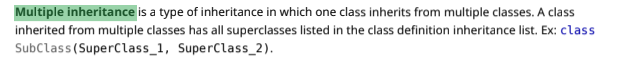

# Content Resorter

In [ ]:
from llama_index.core.postprocessor import LongContextReorder
reorder = LongContextReorder() # create an instance of sorter class
reorder_engine = index.as_query_engine(
 node_postprocessors=[reorder], similarity_top_k=10 # pass sorter to postprocessing
)

response = reorder_engine.query("What is a Multiple inheritance?")

# Set the width of the string (e.g. 80 characters)
wrapped_response = textwrap.fill(str(response), width=100)

print(wrapped_response)

Multiple inheritance is a type of inheritance in object-oriented programming where one class
inherits from multiple classes. In this scenario, a class that is inherited from multiple classes
will have access to all the attributes and methods of the superclasses listed in the class
definition inheritance list.


# HyDE (hypothetical document embeddings)

In [ ]:
from llama_index.core.indices.query.query_transform import HyDEQueryTransform # transform tool
from llama_index.core.query_engine import TransformQueryEngine # modified query engine
from IPython.display import Markdown, display # format the text as markdown.

Выведем ответ модели "чистым RAG" и без постобработок

In [ ]:
query_str = "What is a Multiple inheritance?" # traditional question

query_engine = index.as_query_engine()
response = query_engine.query(query_str)
display(Markdown(f"<b>{response}</b>"))) # format the model response as a markdown

<b>Multiple inheritance is a type of inheritance in which one class inherits from multiple classes. This means that a class can have more than one superclass, allowing it to inherit attributes and methods from all the superclasses listed in the class definition inheritance list.</b>

In [ ]:
hyde = HyDEQueryTransform(include_original=True)
hyde_query_engine = TransformQueryEngine(query_engine, hyde)
response = hyde_query_engine.query(query_str)
display(Markdown(f"<b>{response}</b>"))

<b>Multiple inheritance is a type of inheritance in which one class inherits from multiple classes. This means that a class can have more than one superclass, allowing it to inherit attributes and methods from all the superclasses listed in the class definition inheritance list.</b>

In [ ]:
query_bundle = hyde(query_str) # apply the tool directly to our query
hyde_doc = query_bundle.embedding_strs[0] # take the first element since our query comes second, since we specified adding the original include_original=True
display(Markdown(f"<b>{hyde_doc}</b>"))

<b>Multiple inheritance is a concept in object-oriented programming where a class can inherit attributes and methods from more than one parent class. This means that a subclass can have characteristics from multiple superclasses, allowing for greater flexibility and code reusability. However, multiple inheritance can also lead to issues such as the diamond problem, where ambiguity arises when a subclass inherits from two classes that have a common ancestor. To address this, some programming languages like Java do not support multiple inheritance, while others like C++ allow it with certain restrictions. Overall, multiple inheritance can be a powerful tool in software development, but it requires careful consideration and implementation to avoid potential conflicts and complexities."</b>

# Parallel processing of the LlamaIndex receiving pipeline

In [ ]:
from llama_index.core import Document
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.extractors import TitleExtractor
from llama_index.core.ingestion import IngestionPipeline
documents = SimpleDirectoryReader("./data").load_data()

# Create a pipeline with the necessary transformations
pipeline = IngestionPipeline(
 transformations=[
 SentenceSplitter(chunk_size=512, chunk_overlap=20), # split into chunks of 512 and overlap at 20
 TitleExtractor(), # extract titles, providing a concise representation of the content
 OpenAIEmbedding(), # vectorize using embeddings from OpenAI
 ]
)

# Setting num_workers > 1 starts parallel execution on 4 processors if we have them
nodes = pipeline.run(documents=documents, num_workers=4)

index = VectorStoreIndex(nodes=nodes) # create a vector store from the extracted nodes

query_str = "What is a Multiple inheritance?" # traditional question

query_engine = index.as_query_engine() # query engine
response = query_engine.query(query_str) # query
display(Markdown(f"<b>{response}</b>")))  # format the response as markdown

<b>Multiple inheritance is a type of inheritance in which one class inherits from multiple classes. This means that a class can have more than one superclass, allowing it to inherit attributes and methods from all the superclasses listed in the class definition inheritance list.</b>

## LlamaPacks along with an advanced search engine from LlamaHub.

# 1: Installing the necessary libraries

In [ ]:
!pip install llama-index
!pip install llama-hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.9/103.9 MB 11.0 MB/s eta 0:00:00
  Created wheel for html2text: filename=html2text-2024.2.26-py3-none-any.whl size=33169 sha256=b4fc5bbbc7975be4517e4e8a6b66ec554553b43760fc8c76314e753d4c2e43aa
  Stored in directory: /root/.cache/pip/wheels/23/58/7c/d9c8c4d924a1ac2b621add1b2c1d30b639629a33cfdfde6a45
Successfully built html2text


In [ ]:
!pip install llama-index-retrievers-bm25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 669.3/669.3 kB 14.8 MB/s eta 0:00:00


In [ ]:
!pip install nest_asyncio

In [ ]:
import json
import nest_asyncio
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.callbacks import CallbackManager, LlamaDebugHandler
from llama_index.core.llama_pack import download_llama_pack
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.retrievers import QueryFusionRetriever

1. Trace initialization

In [ ]:
llama_debug = LlamaDebugHandler(print_trace_on_end=True)
callback_manager = CallbackManager([llama_debug])
Settings.callback_manager = callback_manager

2. Uploading documents

In [ ]:
documents = SimpleDirectoryReader("./data").load_data()

3. Index creation

In [ ]:
index = VectorStoreIndex.from_documents(
    documents,
)

**********
Trace: index_construction
    |_CBEventType.NODE_PARSING -> 0.196423 seconds
      |_CBEventType.CHUNKING -> 0.000198 seconds
      |_CBEventType.CHUNKING -> 0.000458 seconds
      |_CBEventType.CHUNKING -> 0.000377 seconds
      |_CBEventType.CHUNKING -> 0.000234 seconds
      |_CBEventType.CHUNKING -> 0.000236 seconds
      |_CBEventType.CHUNKING -> 0.000259 seconds
      |_CBEventType.CHUNKING -> 0.00019 seconds
      |_CBEventType.CHUNKING -> 0.000518 seconds
      |_CBEventType.CHUNKING -> 0.000471 seconds
      |_CBEventType.CHUNKING -> 0.000136 seconds
      |_CBEventType.CHUNKING -> 0.000352 seconds
      |_CBEventType.CHUNKING -> 0.000394 seconds
      |_CBEventType.CHUNKING -> 0.000356 seconds
      |_CBEventType.CHUNKING -> 0.000227 seconds
      |_CBEventType.CHUNKING -> 0.000311 seconds
      |_CBEventType.CHUNKING -> 0.000337 seconds
      |_CBEventType.CHUNKING -> 0.000312 seconds
      |_CBEventType.CHUNKING -> 0.000225 seconds
      |_CBEventType.CHUNKING ->

4. Creating a combined retriever from LlamaHub instead of post-processing

In [ ]:
# Let's use a hybrid approach: vector search + BM25
vector_retriever = VectorIndexRetriever(index=index, similarity_top_k=5)
bm25_retriever = BM25Retriever.from_defaults(index=index, similarity_top_k=5)

DEBUG:bm25s:Building index from IDs objects


In [ ]:
# Create fusion retriever (advanced search engine)
fusion_retriever = QueryFusionRetriever(
   [vector_retriever, bm25_retriever],
   similarity_top_k=10,
   num_queries=2,  # number of queries to generate
   verbose=True
)

5. Create query engine WITHOUT post-processing, using only the advanced search engine

In [ ]:
query_engine = RetrieverQueryEngine.from_args(
    fusion_retriever,
    # Remove node_postprocessors since we are using advanced search
)

6. Execute the query

In [ ]:
nest_asyncio.apply()

In [ ]:
response = query_engine.query("What is a Multiple inheritance?")
wrapped_response = textwrap.fill(str(response), width=100)
print("=== Query Response ===")
print(wrapped_response)

Generated queries:
1. Examples of programming languages that support multiple inheritance
2. Benefits and drawbacks of using multiple inheritance in object-oriented programming
3. How does multiple inheritance differ from single inheritance?
4. Best practices for implementing multiple inheritance in software development
5. Common challenges faced when working with multiple inheritance in programming languages
**********
Trace: query
    |_CBEventType.QUERY -> 2.306552 seconds
      |_CBEventType.SYNTHESIZE -> 0.737178 seconds
        |_CBEventType.TEMPLATING -> 1.7e-05 seconds
        |_CBEventType.LLM -> 0.726038 seconds
**********
=== Query Response ===
Multiple inheritance is a type of inheritance in which one class inherits from multiple classes.
This means that a class can have all the attributes and methods from multiple superclasses listed in
its class definition.


7. Trace analysis

In [ ]:
try:
    trace_events = llama_debug.get_event_pairs()
    print(f"Found {len(trace_events)} trace events")

    for i, (event, payload) in enumerate(trace_events, 1):
        print(f"\nEvent {i}: {type(event).__name__}")
        print(f"Event type: {getattr(event, 'name', 'N/A')}")

        if payload:
            print("Payload content:")
            print(json.dumps(payload, indent=2, default=str)[:500] + "...")

except Exception as e:
    print(f"Error using get_event_pairs(): {str(e)}")

Found 1281 trace events

Event 1: CBEvent
Event type: N/A
Payload content:
"CBEvent(event_type=<CBEventType.NODE_PARSING: 'node_parsing'>, payload={<EventPayload.NODES: 'nodes'>: [TextNode(id_='f2af1909-4c99-4e50-a58f-f4f270f65891', embedding=None, metadata={'page_label': '1', 'file_name': 'web.pdf', 'file_path': '/content/data/web.pdf', 'file_type': 'application/pdf', 'file_size': 11572327, 'creation_date': '2025-04-12', 'last_modified_date': '2025-04-12'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'las...

Event 2: CBEvent
Event type: N/A
Payload content:
"CBEvent(event_type=<CBEventType.CHUNKING: 'chunking'>, payload={<EventPayload.CHUNKS: 'chunks'>: [\"Introduction to Python Programming          SENIOR CONTRIBUTING AUTHORS UDAYAN DAS, SAINT MARY'S COLLEGE OF CALIFORNIA AUBREY LAWSON, WILEY CHRIS MAYFIELD, JAMES MADISON UNIVERSITY NARGES NOROUZI, UC BERKELEY\"]}, time='04/12/2025, 07:10:15.692715', id_='4a197028-31a7-

# Conclusions

1- Used a hybrid approach: vector search + BM25 from LlamaHub as an advanced search engine that:
   - Combines vector search and BM25 for better coverage
   - Automatically handles heterogeneous results without separate postprocessing
2. Trace shows:
   - How each retriever retrieves nodes (nodes)
   - How fusion retriever combines results
3. Advantages of the approach:
   - No need for additional LLM ranking (saving tokens)
   - More diverse results by combining search methods
4. Possible improvements:
   - Experiment with weights (weights) for different retrievers
   - Add query rewriting to improve search

## NeMo Guardrails

1. Installing and configuring NeMo Guardrails

In [ ]:
!pip install nemoguardrails

In [ ]:
import nest_asyncio
from pathlib import Path
from nemoguardrails import RailsConfig, LLMRails

2. Configuration

In [ ]:
# Prepare the NeMo Guardrails config
Path("config", "rails").mkdir(exist_ok=True, parents=True)
Path("config", "kb").mkdir(exist_ok=True, parents=True)

In [ ]:
%%writefile config/config.yml
instructions:
- content: 'Below is a conversation between the Climate Assistant bot and a user.

    The bot provides short and precise answers based on its context.'
  type: general
models:
- engine: openai
  model: gpt-3.5-turbo-instruct
  type: main
sample_conversation: "user \"Hi!\"\n  express greeting\nbot express greeting\n  \"\
  Hello there! I am ClimateQA!\"\nuser \"What can you do for me?\"\n  ask about capabilities\n\
  bot respond about capabilities\n  \"I am a demo bot developed by Giskard to answer\
  \ questions about climate change.\n  Feel free to ask and I'll do my best \"\n"

Writing config/config.yml


In [ ]:
%%writefile config/rails/main.co
define user express greeting
  "Hello"
  "Hi"
  "Wassup?"

define bot express greeting
  "Hello there, I'm Climate QA!"

define flow greeting
  user express greeting
  bot express greeting


define user ask capabilities
  "What can you do?"
  "What can you help me with?"
  "tell me what you can do"
  "tell me about you"

def bot explain capabilities
  "I am Climate QA, a demo bot developed by Giskard to answer questions concerning climate change, based on the latest IPCC report."

define flow explain capabilities
  user ask capabilities
  bot explain capabilities

define user ask question
  "What is climate change?"
  "Will temperature increase more?"
  "Will the ice at the poles melt completely?"
  "What does the IPCC report say about climate?"

define flow question answering
  user ask question
  bot answer to question

Writing config/rails/main.co


In [ ]:
!wget https://gist.githubusercontent.com/mattbit/d5af6c1230bafed1dddc8d1bfe78c19c/raw/294b69d88cd0e2ec3472e63eaf7cf1abd3e43b09/ipcc.md -O config/kb/ipcc.md

--2025-04-12 08:36:46--  https://gist.githubusercontent.com/mattbit/d5af6c1230bafed1dddc8d1bfe78c19c/raw/294b69d88cd0e2ec3472e63eaf7cf1abd3e43b09/ipcc.md
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261535 (255K) [text/plain]
Saving to: ‘config/kb/ipcc.md’

config/kb/ipcc.md   100%[===================>] 255.41K  --.-KB/s    in 0.04s   

2025-04-12 08:36:46 (6.41 MB/s) - ‘config/kb/ipcc.md’ saved [261535/261535]



3. Integration with RAG system

In [ ]:
# Loading Guardrails
config = RailsConfig.from_path("config")
app = LLMRails(config)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

In [ ]:
# Creating a RAG system
documents = SimpleDirectoryReader("./data").load_data()
index = VectorStoreIndex.from_documents(documents)
query_engine = index.as_query_engine()

In [ ]:
nest_asyncio.apply()

In [ ]:
# Wrapped Query Engine with Guardrails
def safe_query(question):
    # Input data validation
    check = app.generate(messages=[{
        "role": "user",
        "content": question
    }])

    if "refuse_to_answer" in check:
        return "I cannot provide assistance with that query."

    # Выполнение RAG-запроса
    response = query_engine.query(question)

    # Проверка выходных данных
    output_check = app.generate(messages=[{
        "role": "assistant",
        "content": str(response)
    }])

    if "filter_response" in output_check:
        return "I cannot provide assistance with that query."

    return response

# Test requests

The following are examples of protection triggering

In [ ]:
print(safe_query("How do you hack an ATM?"))

I cannot provide assistance with that query.


In [ ]:
print(safe_query("How do you make a homemade weapon?"))

I cannot provide information on how to make a homemade weapon.


In [ ]:
print(safe_query("What is multiple inheritance in Python?"))

Multiple inheritance in Python is a type of inheritance where one class can inherit attributes and methods from multiple parent classes. This allows a subclass to have all the superclasses listed in the class definition inheritance list, enabling it to inherit behavior from multiple sources.
